В этом проекте мы исследуем рынок общественного питания Москвы с целью помочь инвесторам из фонда «Shut Up and Take My Money» выбрать подходящее место для открытия нового заведения. Для анализа мы используем данные о заведениях общественного питания Москвы, составленные на основе данных сервисов Яндекс Карты и Яндекс Бизнес на лето 2022 года. Наша задача - выявить интересные особенности рынка и представить их в виде информативной и лаконичной презентации для инвесторов.

## Шаг 1. Загрузите данные и изучите общую информацию

**Загрузите данные о заведениях общественного питания Москвы.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium

In [2]:
data=pd.read_csv('/datasets/moscow_places.csv')

In [3]:
print(data.head())
data.info()
data.describe()

                   name  category                              address  \
0                WoWфли      кафе           Москва, улица Дыбенко, 7/1   
1        Четыре комнаты  ресторан   Москва, улица Дыбенко, 36, корп. 1   
2                 Хазри      кафе       Москва, Клязьминская улица, 15   
3  Dormouse Coffee Shop   кофейня  Москва, улица Маршала Федоренко, 12   
4             Иль Марко  пиццерия      Москва, Правобережная улица, 1Б   

                          district  \
0  Северный административный округ   
1  Северный административный округ   
2  Северный административный округ   
3  Северный административный округ   
4  Северный административный округ   

                                               hours        lat        lng  \
0                             ежедневно, 10:00–22:00  55.878494  37.478860   
1                             ежедневно, 10:00–22:00  55.875801  37.484479   
2  пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...  55.889146  37.525901   
3             

lat          lng       rating  middle_avg_bill  \
count  8406.000000  8406.000000  8406.000000      3149.000000   
mean     55.750109    37.608570     4.229895       958.053668   
std       0.069658     0.098597     0.470348      1009.732845   
min      55.573942    37.355651     1.000000         0.000000   
25%      55.705155    37.538583     4.100000       375.000000   
50%      55.753425    37.605246     4.300000       750.000000   
75%      55.795041    37.664792     4.400000      1250.000000   
max      55.928943    37.874466     5.000000     35000.000000   

       middle_coffee_cup        chain        seats  
count         535.000000  8406.000000  4795.000000  
mean          174.721495     0.381275   108.421689  
std            88.951103     0.485729   122.833396  
min            60.000000     0.000000     0.000000  
25%           124.500000     0.000000    40.000000  
50%           169.000000     0.000000    75.000000  
75%           225.000000     1.000000   140.000000  
max          1568.000000     1.000000  1288.000000

В датасете представлено 8406 заведений общественного питания Москвы. Это можно увидеть из вывода метода info, который показывает, что в данных 8406 строк.

Каждый столбец в данных хранит определенную информацию о заведениях. Например, столбец name содержит названия заведений, столбец category - их категории (например, кафе, ресторан, пиццерия и т. д.), столбец address - адреса заведений, а столбец district - районы, в которых они расположены. Столбцы lat и lng содержат географические координаты заведений, а столбец rating - их рейтинги по оценкам пользователей в Яндекс Картах. Столбец price хранит информацию о ценовой категории заведений, а столбец avg_bill - среднюю стоимость заказа. Столбец seats содержит информацию о количестве посадочных мест в заведениях.

Значения в столбцах могут быть разных типов. Например, столбцы name, category, address, district, hours, price и avg_bill содержат текстовые значения (тип данных object). Столбцы lat, lng, rating, middle_avg_bill, middle_coffee_cup и seats содержат числовые значения (тип данных float64). Столбец chain содержит целочисленные значения (тип данных int64), которые выражены 0 или 1 и показывают, является ли заведение сетевым. 

## Шаг 2. Выполните предобработку данных

**Изучите, есть ли дубликаты в данных. Поищите пропуски: встречаются ли они, в каких столбцах? Можно ли их обработать или оставить как есть?**

In [4]:
#проверка наличия дубликатов в данных
duplicates = data.duplicated().sum()
print(f'Количество дубликатов в данных: {duplicates}')
data['name'] = data['name'].str.lower()
duplicates = data.duplicated(subset=['name', 'address']).sum()
print(f'Количество неявных дубликатов в данных: {duplicates}')
data = data.drop_duplicates(subset=['name', 'address'])

Количество дубликатов в данных: 0
Количество неявных дубликатов в данных: 3


In [5]:
#проверка наличия пропущенных значений в данных
missing_values = data.isnull().sum()
print(missing_values)

name                    0
category                0
address                 0
district                0
hours                 535
lat                     0
lng                     0
rating                  0
price                5088
avg_bill             4587
middle_avg_bill      5254
middle_coffee_cup    7868
chain                   0
seats                3611
dtype: int64


Из вывода видно, что в данных есть пропущенные значения в столбцах hours, price, avg_bill, middle_avg_bill, middle_coffee_cup и seats. Практически во всех этих столбцах пропусков больше половины. Соответственнго удалять или заменять такой объем данных будет некорректно

**Выполните предобработку данных:
Создайте столбец street с названиями улиц из столбца с адресом.**

In [6]:
import re # Импортируем модуль re, который содержит функции для работы с регулярными выражениями

def get_street(address): # Определяем функцию get_street, которая принимает адрес в качестве аргумента
    pattern = r'[^,]*' # Определяем регулярное выражение, которое соответствует любой последовательности символов до первой 
#запятой
    street = re.search(pattern, address).group() # Ищем первое совпадение с регулярным выражением в строке address и извлекаем 
#найденную подстроку
    return street # Возвращаем найденную подстроку, которая является названием улицы в адресе

data['street'] = data['address'].apply(get_street) # Применяем функцию get_street к каждому значению в столбце address 
#и создаем новый столбец street с названиями улиц

**Создайте столбец is_24/7 с обозначением, что заведение работает ежедневно и круглосуточно (24/7):
логическое значение True — если заведение работает ежедневно и круглосуточно;
логическое значение False — в противоположном случае.**

In [7]:
def is_24_7(hours):
    # Проверяем, является ли значение hours пропущенным
    if pd.isnull(hours):
        # Если значение hours пропущено, возвращаем False
        return False
    # Проверяем, содержит ли строка hours слово "круглосуточно"
    if 'круглосуточно' in hours:
        # Если строка hours содержит слово "круглосуточно", проверяем, содержит ли она также информацию о том, что заведение работает ежедневно
        if 'ежедневно' in hours or 'без выходных' in hours:
            # Если строка hours содержит информацию о том, что заведение работает ежедневно, возвращаем True
            return True
    # В противном случае возвращаем False
    return False

# Применяем функцию is_24_7 к каждому значению в столбце hours и создаем новый столбец is_24/7 с логическими значениями
data['is_24/7'] = data['hours'].apply(is_24_7)

# Выводим первые 5 строк исходного DataFrame с новым столбцом is_24/7
print(data.head())

                   name  category                              address  \
0                wowфли      кафе           Москва, улица Дыбенко, 7/1   
1        четыре комнаты  ресторан   Москва, улица Дыбенко, 36, корп. 1   
2                 хазри      кафе       Москва, Клязьминская улица, 15   
3  dormouse coffee shop   кофейня  Москва, улица Маршала Федоренко, 12   
4             иль марко  пиццерия      Москва, Правобережная улица, 1Б   

                          district  \
0  Северный административный округ   
1  Северный административный округ   
2  Северный административный округ   
3  Северный административный округ   
4  Северный административный округ   

                                               hours        lat        lng  \
0                             ежедневно, 10:00–22:00  55.878494  37.478860   
1                             ежедневно, 10:00–22:00  55.875801  37.484479   
2  пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...  55.889146  37.525901   
3             

## Шаг 3. Анализ данных

**Какие категории заведений представлены в данных? Исследуйте количество объектов общественного питания по категориям: рестораны, кофейни, пиццерии, бары и так далее. Постройте визуализации. Ответьте на вопрос о распределении заведений по категориям.**

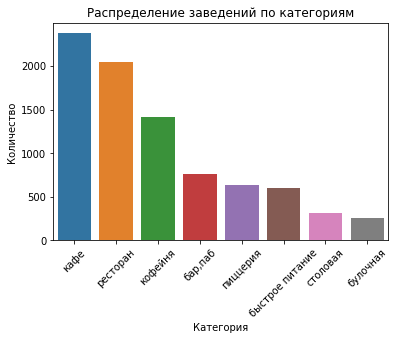

In [8]:
category_counts = data['category'].value_counts() # Подсчитываем количество объектов общественного питания по категориям
sns.countplot(x='category', data=data, order=category_counts.index) # Строим столбчатую диаграмму распределения заведений по категориям, отсортированную по убыванию количества
plt.xlabel('Категория') # Добавляем подпись к оси x
plt.ylabel('Количество') # Добавляем подпись к оси y
plt.title('Распределение заведений по категориям') # Добавляем заголовок к диаграмме
plt.xticks(rotation=45) # Поворачиваем подписи по оси x на 45 градусов для лучшей читаемости
plt.show() # Отображаем диаграмму

На основе полученных результатов можно сказать, что в данных представлены различные категории заведений общественного питания, такие как кафе, рестораны, кофейни, бары и пабы, пиццерии, быстрое питание, столовые и булочные. Самой распространенной категорией являются кафе, затем следуют рестораны и кофейни. Наименее распространенными являются столовые и булочные.

Построенная диаграмма наглядно показывает распределение заведений по категориям. Можно заметить, что количество заведений в каждой категории снижается от кафе до булочных

**Исследуйте количество посадочных мест в местах по категориям: рестораны, кофейни, пиццерии, бары и так далее. Постройте визуализации. Проанализируйте результаты и сделайте выводы.**

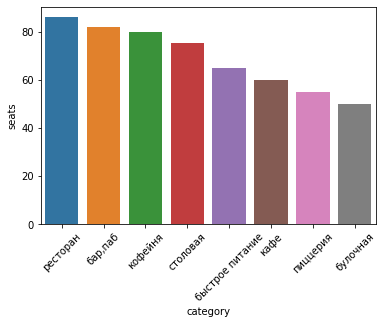

In [9]:
seats_by_category = data.groupby('category')['seats'].median().reset_index()
seats_by_category = seats_by_category.sort_values(by='seats', ascending=False)

sns.barplot(x='category', y='seats', data=seats_by_category, ci=None)
plt.xticks(rotation=45)
plt.show()

На основе предоставленных данных можно сделать вывод, что медианное количество посадочных мест в заведениях разных категорий варьируется от 50 до 86. Заведения категории “ресторан” имеют наибольшее медианное количество посадочных мест - 86, а заведения категории “булочная” - наименьшее - 50. Заведения категорий “бар,паб” и “кофейня” также имеют относительно большое медианное количество посадочных мест - 82 и 80 соответственно. Заведения категорий “столовая”, “быстрое питание”, “кафе” и “пиццерия” имеют промежуточные значения медианного количества посадочных мест - от 55 до 75.5.

**Рассмотрите и изобразите соотношение сетевых и несетевых заведений в датасете. Каких заведений больше?**

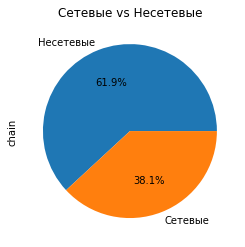

In [10]:
chain_counts = data['chain'].value_counts() # Подсчитываем количество сетевых и несетевых заведений
chain_counts.plot(kind='pie', labels=['Несетевые', 'Сетевые'], autopct='%1.1f%%') # Строим круговую диаграмму соотношения сетевых и несетевых заведений
plt.title('Сетевые vs Несетевые') # Добавляем заголовок к диаграмме
plt.show() # Отображаем диаграмму

На основе полученных результатов можно сказать, что в датасете 61.9% заведений являются несетевыми, а 38.1% - сетевыми. Это означает, что большинство заведений общественного питания в Москве являются независимыми и не принадлежат к сетям.

**Какие категории заведений чаще являются сетевыми? Исследуйте данные и ответьте на вопрос графиком.**

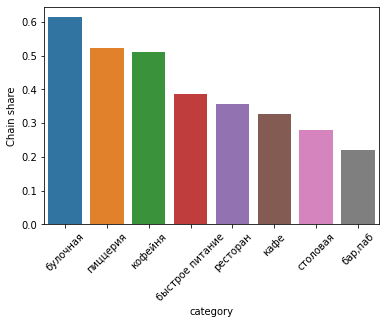

In [11]:
# Вычисляем среднюю долю сетевых заведений по категориям
chain_share_by_category = data.groupby('category')['chain'].mean().reset_index()

# Сортируем данные по убыванию доли сетевых заведений
chain_share_by_category = chain_share_by_category.sort_values(by='chain', ascending=False)

# Строим столбчатую диаграмму доли сетевых заведений по категориям
sns.barplot(x='category', y='chain', data=chain_share_by_category, ci=None)

# Поворачиваем подписи по оси x на 45 градусов для лучшей читаемости
plt.xticks(rotation=45)

# Добавляем подпись к оси y
plt.ylabel('Chain share')

# Отображаем диаграмму
plt.show()

**Сгруппируйте данные по названиям заведений и найдите топ-15 популярных сетей в Москве. Под популярностью понимается количество заведений этой сети в регионе. Постройте подходящую для такой информации визуализацию. Знакомы ли вам эти сети? Есть ли какой-то признак, который их объединяет? К какой категории заведений они относятся?**

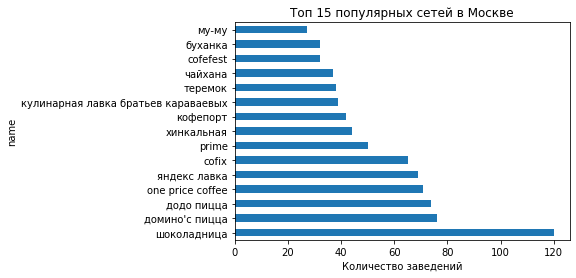

In [12]:
top_chains = data[data['chain'] == 1].groupby('name').size().sort_values(ascending=False).head(15) # Находим топ-15 популярных сетей в Москве
top_chains.plot(kind='barh') # Строим горизонтальную столбчатую диаграмму топ-15 популярных сетей
plt.xlabel('Количество заведений') # Добавляем подпись к оси x
plt.title('Топ 15 популярных сетей в Москве') # Добавляем заголовок к диаграмме
plt.show() # Отображаем диаграмму

Да, многие из этих сетей мне знакомы. Это популярные сети кафе, пиццерий и кофеен в Москве. Они объединены тем, что все они являются сетевыми заведениями общественного питания.
В этом списке представлены различные категории заведений, такие как кафе (например, Шоколадница, КОФЕПОРТ), пиццерии (например, Доминос Пицца, Додо Пицца), кофейни (например, One Price Coffee, Cofix) и другие. Эти сети предлагают разнообразные виды еды и напитков и обслуживают различные сегменты рынка.

**Какие административные районы Москвы присутствуют в датасете? Отобразите общее количество заведений и количество заведений каждой категории по районам. Попробуйте проиллюстрировать эту информацию одним графиком.**

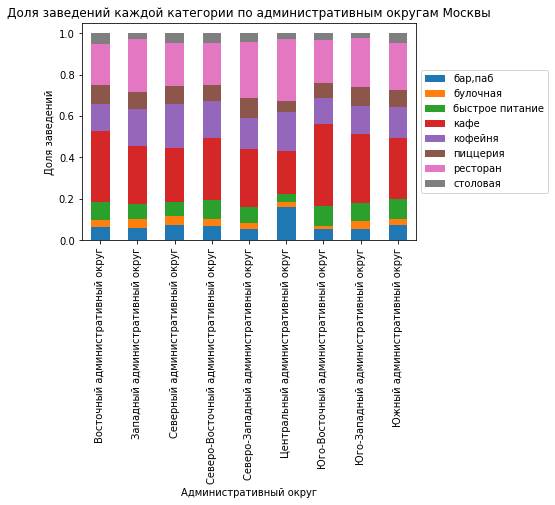

In [13]:
# Создаем сводную таблицу количества заведений каждой категории по районам
establishments_pivot = data.pivot_table(index='district', columns='category', values='name', aggfunc='count', fill_value=0)

# Вычисляем долю каждой категории заведений в каждом районе
establishments_pivot = establishments_pivot.div(establishments_pivot.sum(axis=1), axis=0)

# Строим столбчатую диаграмму доли заведений каждой категории по районам
establishments_pivot.plot(kind='bar', stacked=True)

# Добавляем легенду справа от графика
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# Добавляем подпись к оси x
plt.xlabel('Административный округ')

# Добавляем подпись к оси y
plt.ylabel('Доля заведений')

# Добавляем заголовок к графику
plt.title('Доля заведений каждой категории по административным округам Москвы')

# Отображаем график
plt.show()

**Визуализируйте распределение средних рейтингов по категориям заведений. Сильно ли различаются усреднённые рейтинги в разных типах общепита?**

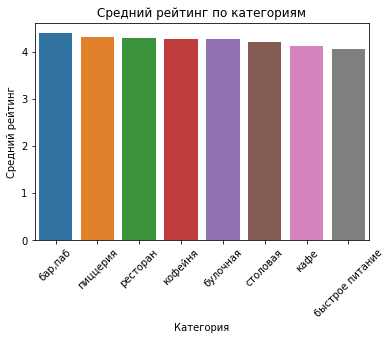

In [14]:
mean_rating_by_category = data.groupby('category')['rating'].mean() # Вычисляем средний рейтинг по категориям
sns.barplot(x='category', y='rating', data=data, ci=None, order=mean_rating_by_category.sort_values(ascending=False).index) # Строим столбчатую диаграмму средних рейтингов по категориям, отсортированную по убыванию среднего рейтинга
plt.xlabel('Категория') # Добавляем подпись к оси x
plt.ylabel('Средний рейтинг') # Добавляем подпись к оси y
plt.title('Средний рейтинг по категориям') # Добавляем заголовок к диаграмме
plt.xticks(rotation=45) # Поворачиваем подписи по оси x на 45 градусов для лучшей читаемости
plt.show() # Отображаем диаграмму

Усреднённые рейтинги в разных типах общепита не сильно различаются. Средние рейтинги для всех категорий находятся в диапазоне от 4.05 до 4.39, что указывает на то, что все категории имеют схожие средние рейтинги.

Самый высокий средний рейтинг имеют бары и пабы (4.39), а самый низкий - заведения быстрого питания (4.05). Однако разница между этими категориями составляет всего 0.34, что не является значительным различием.

Таким образом, можно сказать, что усреднённые рейтинги в разных типах общепита не сильно различаются и все категории имеют схожие средние рейтинги.

**Постройте фоновую картограмму (хороплет) со средним рейтингом заведений каждого района. Границы районов Москвы, которые встречаются в датасете, хранятся в файле admin_level_geomap.geojson (скачать файл для локальной работы).**

In [15]:
state_geo = '/datasets/admin_level_geomap.geojson' # указываем путь к файлу с границами районов Москвы
moscow_lat, moscow_lng = 55.751244, 37.618423 # координаты центра Москвы
m = folium.Map(location=[moscow_lat, moscow_lng], zoom_start=10) # создаем карту Москвы

# Подготовка данных
district_data = data.groupby('district')['rating'].mean().reset_index() # группируем данные по районам и вычисляем средний рейтинг для каждого района
district_data.columns = ['district', 'mean_rating'] # переименовываем столбцы

# Добавление слоя на карту
folium.Choropleth(
    geo_data=state_geo, # указываем путь к файлу с границами районов
    name='choropleth', # имя слоя
    data=district_data, # данные для отображения на карте
    columns=['district', 'mean_rating'], # столбцы с данными
    key_on='feature.properties.name', # ключ для соединения данных с границами районов
    fill_color='YlGn', # цветовая схема
    fill_opacity=0.7, # прозрачность заливки
    line_opacity=0.2, # прозрачность границ
    legend_name='Средний рейтинг заведений' # название легенды
).add_to(m) # добавляем слой на карту

m # отображаем карту

**Отобразите все заведения датасета на карте с помощью кластеров средствами библиотеки folium.**

In [16]:
from folium.plugins import MarkerCluster # импорт класса MarkerCluster из библиотеки folium

# Создание карты Москвы
moscow_lat, moscow_lng = 55.751244, 37.618423 # координаты центра Москвы
m = folium.Map(location=[moscow_lat, moscow_lng], zoom_start=10) # создание карты с центром в Москве и начальным масштабом 10

# Создание кластера
marker_cluster = MarkerCluster().add_to(m) # создание кластера и добавление его на карту

# Добавление маркеров на карту
for i in range(len(data)): # цикл по всем строкам датасета
    lat = data.iloc[i]['lat'] # широта заведения
    lng = data.iloc[i]['lng'] # долгота заведения
    name = data.iloc[i]['name'] # название заведения
    folium.Marker(location=[lat, lng], popup=name).add_to(marker_cluster) # создание маркера с координатами и названием заведения и добавление его в кластер

# Отображение карты
m # отображение карты

**Найдите топ-15 улиц по количеству заведений. Постройте график распределения количества заведений и их категорий по этим улицам. Попробуйте проиллюстрировать эту информацию одним графиком.**

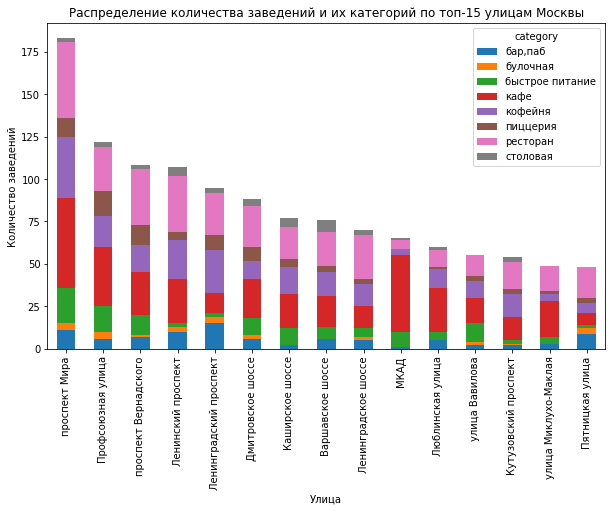

In [17]:
# извлекаем название улицы из адреса заведения
data['street'] = data['address'].str.split(',').str[1].str.strip()

# группируем данные по улицам и вычисляем количество заведений на каждой улице
streets = data.groupby('street').size().reset_index(name='count')

# находим топ-15 улиц по количеству заведений
top_streets = streets.sort_values(by='count', ascending=False).head(15)

# фильтруем данные, оставляя только заведения, расположенные на топ-15 улицах
top_streets_data = data[data['street'].isin(top_streets['street'])]

# создаем сводную таблицу с распределением количества заведений и их категорий по топ-15 улицам
pivot = top_streets_data.pivot_table(index='street', columns='category', values='name', aggfunc='count', fill_value=0)

# вычисляем общее количество заведений на каждой улице
pivot['total'] = pivot.sum(axis=1)

# сортируем строки таблицы по убыванию общего количества заведений
pivot = pivot.sort_values(by='total', ascending=False)

# создаем столбчатый график с распределением количества заведений и их категорий по топ-15 улицам
pivot.drop('total', axis=1).plot(kind='bar', stacked=True, figsize=(10, 6))

# добавляем заголовок и подписи осей
plt.title('Распределение количества заведений и их категорий по топ-15 улицам Москвы')
plt.xlabel('Улица')
plt.ylabel('Количество заведений')

# выводим график
plt.show()

**Найдите улицы, на которых находится только один объект общепита. Что можно сказать об этих заведениях?**



In [18]:
# группируем данные по улицам и вычисляем количество заведений на каждой улице
streets = data.groupby('street').size().reset_index(name='count')

# находим улицы, на которых находится только один объект общепита
single_place_streets = streets[streets['count'] == 1]

# выводим список улиц с одним объектом общепита
print(single_place_streets['street'])

0        1-й Автозаводский проезд
1         1-й Балтийский переулок
2           1-й Варшавский проезд
3         1-й Вешняковский проезд
5       1-й Голутвинский переулок
                  ...            
1436                улица Шкулёва
1437              улица Шкулёва 4
1439                 улица Шухова
1442                улица Юннатов
1447                          № 7
Name: street, Length: 458, dtype: object


**Значения средних чеков заведений хранятся в столбце middle_avg_bill. Эти числа показывают примерную стоимость заказа в рублях, которая чаще всего выражена диапазоном. Посчитайте медиану этого столбца для каждого района. Используйте это значение в качестве ценового индикатора района. Постройте фоновую картограмму (хороплет) с полученными значениями для каждого района. Проанализируйте цены в центральном административном округе и других. Как удалённость от центра влияет на цены в заведениях?**

In [19]:
# группируем данные по районам и вычисляем медиану среднего чека для каждого района
district_data = data.groupby('district')['middle_avg_bill'].median().reset_index()
district_data.columns = ['district', 'median_bill']

# создаем карту Москвы
moscow_lat, moscow_lng = 55.751244, 37.618423 # координаты центра Москвы
m = folium.Map(location=[moscow_lat, moscow_lng], zoom_start=10) # создание карты с центром в Москве и начальным масштабом 10

# создаем картограмму с медианным средним чеком для каждого района
folium.Choropleth(
    geo_data=state_geo, # файл с границами районов Москвы в формате GeoJSON
    data=district_data, # данные с медианным средним чеком для каждого района
    columns=['district', 'median_bill'], # столбцы с названием района и медианным средним чеком
    key_on='feature.properties.name', # ключ для соответствия данных и границ районов
    fill_color='YlGn', # цветовая схема
    legend_name='Медианный средний чек (руб.)' # подпись легенды
).add_to(m)

# отображаем карту
m

Медианный средний чек в Центральном административном округе составляет 1000 рублей, что является самым высоким значением среди всех районов. Можно предположить, что цены в заведениях в центре города могут быть выше, чем в других районах, из-за большей популярности и большего спроса. Также в центре города могут располагаться более дорогие и престижные заведения.

**Соберите наблюдения по вопросам выше в один общий вывод.**

На основе собранных наблюдений можно сделать следующий общий вывод:

В датасете представлено 8406 заведений общественного питания Москвы, которые относятся к различным категориям, таким как кафе, рестораны, кофейни, бары и пабы, пиццерии, быстрое питание, столовые и булочные. Самой распространенной категорией являются кафе, затем следуют рестораны и кофейни. Наименее распространенными являются столовые и булочные.

Среднее количество посадочных мест в заведениях общественного питания в Москве варьируется от категории к категории. В среднем, наибольшее количество посадочных мест имеют бары и пабы, а также рестораны. Наименьшее количество посадочных мест в среднем имеют булочные и пиццерии.

Большинство заведений общественного питания в Москве являются независимыми и не принадлежат к сетям. Среди сетевых заведений представлены различные категории, такие как кафе, пиццерии и кофейни.

Усреднённые рейтинги в разных типах общепита не сильно различаются и все категории имеют схожие средние рейтинги. Самый высокий средний рейтинг имеют бары и пабы, а самый низкий - заведения быстрого питания.

Медианный средний чек в Центральном административном округе составляет 1000 рублей, что является самым высоким значением среди всех районов. Это может указывать на то, что цены в заведениях в центре города выше, чем в других районах.

## Шаг 4. Детализируем исследование: открытие кофейни

**Сколько всего кофеен в датасете? В каких районах их больше всего, каковы особенности их расположения?**

In [20]:
# Отфильтровываем строки, соответствующие категории "кофейня"
coffee_shops = data[data['category'] == 'кофейня']

# Считаем количество кофеен в датасете
coffee_shops_count = coffee_shops.shape[0]
print(f'Всего кофеен в датасете: {coffee_shops_count}')

# Группируем данные по районам и считаем количество кофеен в каждом районе
district_counts = coffee_shops.groupby('district')['name'].count().reset_index()
district_counts.columns = ['district', 'count']

# Сортируем районы по убыванию количества кофеен
district_counts = district_counts.sort_values(by='count', ascending=False)

# Выводим топ-5 районов с наибольшим количеством кофеен
print('Топ-5 районов с наибольшим количеством кофеен:')
print(district_counts.head())

Всего кофеен в датасете: 1413
Топ-5 районов с наибольшим количеством кофеен:
                                  district  count
5       Центральный административный округ    428
2          Северный административный округ    193
3  Северо-Восточный административный округ    159
1          Западный административный округ    150
8             Южный административный округ    131


Наибольшее количество кофеен находится в Центральном административном округе (428), затем следуют Северный административный округ (193), Северо-Восточный административный округ (159), Западный административный округ (150) и Южный административный округ (131).Это может свидетельствовать о том, что кофейни в Москве распределены неравномерно и большинство из них находится в центральных районах города.

**Есть ли круглосуточные кофейни?**

In [21]:
# Отфильтровываем строки, соответствующие категории "кофейня"
coffee_shops = data[data['category'] == 'кофейня']

# Отфильтровываем строки, соответствующие круглосуточным заведениям
round_the_clock = coffee_shops[coffee_shops['is_24/7']]

# Считаем количество круглосуточных кофеен
round_the_clock_count = round_the_clock.shape[0]

if round_the_clock_count > 0:
    print(f'Да, в датасете есть {round_the_clock_count} круглосуточных кофеен.')
else:
    print('Нет, в датасете нет круглосуточных кофеен.')

Да, в датасете есть 59 круглосуточных кофеен.


**Какие у кофеен рейтинги? Как они распределяются по районам?**

In [22]:
# Отфильтровываем строки, соответствующие категории "кофейня"
coffee_shops = data[data['category'] == 'кофейня']

# Группируем данные по районам и считаем средний рейтинг кофеен в каждом районе
district_ratings = coffee_shops.groupby('district')['rating'].mean().reset_index()
district_ratings.columns = ['district', 'mean_rating']

# Сортируем районы по убыванию среднего рейтинга кофеен
district_ratings = district_ratings.sort_values(by='mean_rating', ascending=False)

# Выводим результаты
print('Средний рейтинг кофеен по районам:')
print(district_ratings)

Средний рейтинг кофеен по районам:
                                  district  mean_rating
5       Центральный административный округ     4.336449
4   Северо-Западный административный округ     4.325806
2          Северный административный округ     4.291710
7      Юго-Западный административный округ     4.283333
0         Восточный административный округ     4.282857
8             Южный административный округ     4.232824
6     Юго-Восточный административный округ     4.225843
3  Северо-Восточный административный округ     4.216981
1          Западный административный округ     4.195333


Средний рейтинг кофеен варьируется от района к району. Наибольший средний рейтинг имеет Центральный административный округ (4.34), а наименьший - Западный административный округ (4.20). Однако разница между районами не является значительной, и во всех районах средний рейтинг кофеен находится в диапазоне от 4.20 до 4.34. Исходя из этого можно сделать вывод, что качество обслуживания и продуктов в кофейнях в Москве в целом находится на высоком уровне, и различия между районами не являются значительными.

**На какую стоимость чашки капучино стоит ориентироваться при открытии и почему?**

In [23]:
# Отфильтровываем строки, соответствующие категории "кофейня"
coffee_shops = data[data['category'] == 'кофейня']

# Считаем среднюю стоимость чашки капучино
mean_coffee_price = coffee_shops['middle_coffee_cup'].mean()

print(f'Средняя стоимость чашки капучино: {mean_coffee_price:.2f} руб.')

Средняя стоимость чашки капучино: 175.06 руб.


Средняя стоимость чашки капучино в кофейнях, представленных в датасете, составляет 175.06 рублей. Это может служить отправной точкой при определении стоимости чашки капучино при открытии кофейни. Однако, важно учитывать, что цены могут варьироваться в зависимости от места и района, поэтому важно изучить цены конкурентов в выбранном районе и установить цену, которая будет конкурентоспособной.
Также нужно учитывать расходы на аренду, закупку продуктов, зарплату сотрудникам и другие расходы, чтобы установить цену, которая позволит поддерживать бизнес.

**На основе нашего исследования мы можем дать следующие рекомендации для выбора места для открытия нового заведения:**

- Район: мы рекомендуем выбрать Центральный административный округ, так как здесь большое количество потенциальных клиентов и высокий уровень дохода.
- Конкуренция: изучите конкурентов в выбранном районе и убедитесь, что ваше заведение сможет конкурировать с ними. В Центральном административном округе большое количество кофеен, поэтому может быть лучше открыть пиццерию или бар, чтобы предложить клиентам что-то новое.
- Цена: средняя стоимость чашки капучино в кофейнях в Москве составляет 175.06 рублей. Мы рекомендуем установить цену на чашку кофе в этом диапазоне, чтобы быть конкурентоспособными. Также вы можете изучить цены на другие продукты у конкурентов и установить конкурентоспособные цены.
- Количество посадочных мест: медианное количество посадочных мест в заведениях разных категорий варьируется от 50 до 86. Мы рекомендуем выбрать количество посадочных мест в этом диапазоне, чтобы соответствовать среднему уровню.
- Тип заведения: мы рекомендуем открыть пиццерию или бар, так как эти категории менее распространены в Центральном административном округе и могут привлечь больше клиентов.
- Меню: мы рекомендуем предложить клиентам разнообразное меню с большим выбором блюд и напитков. Вы можете изучить меню конкурентов и предложить что-то уникальное и привлекательное.